In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest
import patsy

In [4]:
crimes = pd.read_csv('~/data/CrimesSmall.csv')

In [6]:
crimes.index = crimes['ID'] # make the index the actual case number
# remove columns that are unnecessary for the analysis and would probably just slow our code down
crimes = crimes.drop(['Beat', 'FBI Code','Updated On', 'Case Number', 'Block', 'IUCR', 'ID', 'Description', 'Ward', 'X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude'], axis=1)




In [7]:
crime_types = crimes['Primary Type'].unique().tolist()

### Begin cleaning data

1. Remove NaN values
2. standardize the crime type to get rid of the uppercase, standardize the non-criminal type
3. standardize the location description

There are actually no Nan values to remove! Government data is reliable I guess. The only NaN values are location, but we still know the district, so as long as we don't end up needing location later on, this is fine

In [8]:
to_drop = crimes[crimes.isnull().any(axis=1)]
to_drop;

In [9]:
def standardize_primary_type(string):
    # compile all non-criminal offenses into on label
    if string == 'NON-CRIMINAL (SUBJECT SPECIFIED)' or string == 'NON - CRIMINAL' or string == 'NON-CRIMINAL':
        return 'non-criminal'
    if string == 'OTHER OFFENSE':
        return 'other'
    # rename crim sexual assault to just sexual assault to make it easier to read
    if string == 'CRIM SEXUAL ASSAULT':
        return 'sexual assault'
    else:
        # everything else, make sure to lowercase it so we don't have to use caps lock lol
        return string.lower()
        

In [10]:
def standardize_location(string):
    if type(string) == str:
        string = string.lower()
        if 'airport' in string:
            return 'airport'
    return string

In [11]:
crimes['Primary Type'] = crimes['Primary Type'].apply(standardize_primary_type) # clean data 
crimes['location'] = crimes['Location Description'].apply(standardize_location)

In [12]:
# be careful if you run this one, only run it once it won't work the second time 
crimes = crimes.drop(['Location Description','Community Area'],axis=1)

In [13]:
crimes = crimes.rename(columns = {'Location': 'Coordinates'})

In [14]:
violents = ['BATTERY','ASSAULT','CRIM SEXUAL ASSAULT', 'ARSON','HOMICIDE']

In [15]:
violent_crimes = crimes[ (crimes['Primary Type'] == 'battery') | (crimes['Primary Type'] == 'assault') | (crimes['Primary Type'] == 'sexual assault') | (crimes['Primary Type'] == 'arson') | (crimes['Primary Type'] == 'homicide')]

In [16]:
crimes.head()

,Date,Primary Type,Arrest,Domestic,District,Year,Coordinates,location
ID,,,,,,,,
7956475,3/4/2011 10:52,assault,True,False,10,2011,"(41.84558589, -87.731082337)","school, public, building"
7956476,3/4/2011 12:00,deceptive practice,False,False,9,2011,"(41.811145384, -87.685707211)",residence
7956477,3/4/2011 9:00,criminal damage,False,False,18,2011,"(41.924756753, -87.668780552)",residence
7956479,3/3/2011 8:00,theft,False,False,5,2011,"(41.712529985, -87.631672138)",residential yard (front/back)
7956480,3/4/2011 10:35,battery,True,False,16,2011,"(41.98287878, -87.791440835)","school, public, building"


## Overall, our question is, does the district a crime was committed in or the type of crime predict whether an arrest was made for that crime

First, I will fit a linear regression model to see how district predicts arrest rate.
1. Create a dataframe with index being the district, one column is the arrest rate for a particular crime, we will look at the top three crimes. 

In [17]:
crimes['Primary Type'].value_counts().nlargest(3)

battery      418
theft        383
narcotics    266
Name: Primary Type, dtype: int64

In [18]:
districts = crimes['District'].unique().tolist()
districts.remove(21)

ValueError: list.remove(x): x not in list

In [19]:
district_cache = {}
for district in districts:
    district_cache[district] = crimes[ crimes['District'] == district ]

In [20]:
dist_pred_arrest = pd.DataFrame()
for district in districts:
    
    district_df = district_cache[district]
    
    arrest_occurred = district_df[district_df['Arrest'] == True]
    
    dist_pred_arrest.loc[district,'Reported Theft'] = len(district_df[district_df['Primary Type'] == 'theft'])
    dist_pred_arrest.loc[district,'Theft w/ Arrest Made'] = len(arrest_occurred[arrest_occurred['Primary Type'] == 'theft'])
    dist_pred_arrest.loc[district,'Theft Arrest Rate'] = dist_pred_arrest.loc[district,'Theft w/ Arrest Made'] / dist_pred_arrest.loc[district,'Reported Theft']

    dist_pred_arrest.loc[district,'Reported Battery'] = len(district_df[district_df['Primary Type'] == 'battery'])
    dist_pred_arrest.loc[district,'Battery w/ Arrest Made'] = len(arrest_occurred[arrest_occurred['Primary Type'] == 'battery'])
    dist_pred_arrest.loc[district,'Battery Arrest Rate'] = dist_pred_arrest.loc[district,'Battery w/ Arrest Made'] / dist_pred_arrest.loc[district,'Reported Battery']

    
    dist_pred_arrest.loc[district,'Reported Criminal Damage'] = len(district_df[district_df['Primary Type'] == 'criminal damage'])
    dist_pred_arrest.loc[district,'Criminal Damage w/ Arrest Made'] = len(arrest_occurred[arrest_occurred['Primary Type'] == 'criminal damage'])
    dist_pred_arrest.loc[district,'Criminal Damage Arrest Rate'] = dist_pred_arrest.loc[district,'Criminal Damage w/ Arrest Made'] / dist_pred_arrest.loc[district,'Reported Criminal Damage']

    
    
    
    


In [21]:
assert 21 not in dist_pred_arrest.index

In [22]:
dist_pred_arrest = dist_pred_arrest.sort_index()
dist_pred_arrest['District'] = dist_pred_arrest.index
dist_pred_arrest['Theft Arrest Rate'].values

array([0.21212121, 0.14285714, 0.06666667, 0.1       , 0.        ,
       0.21428571, 0.08695652, 0.16      , 0.1       , 0.        ,
       0.125     , 0.        , 0.04347826, 0.2       , 0.        ,
       0.07692308, 0.34210526, 0.125     , 0.        , 0.125     ,
       0.25      , 0.28571429])

In [23]:
print('Max arrest rate: {0}\tDistrict: {1}'.format(dist_pred_arrest['Theft Arrest Rate'].max(),dist_pred_arrest['Theft Arrest Rate'].idxmax()))
print('Min arrest rate: {0}\tDistrict: {1}'.format(dist_pred_arrest['Theft Arrest Rate'].min(),dist_pred_arrest['Theft Arrest Rate'].idxmin()))



Max arrest rate: 0.34210526315789475	District: 18
Min arrest rate: 0.0	District: 5


In [24]:
crimes = crimes.rename(columns={'Primary Type': 'Type'})

In [25]:
crimes.head()

,Date,Type,Arrest,Domestic,District,Year,Coordinates,location
ID,,,,,,,,
7956475,3/4/2011 10:52,assault,True,False,10,2011,"(41.84558589, -87.731082337)","school, public, building"
7956476,3/4/2011 12:00,deceptive practice,False,False,9,2011,"(41.811145384, -87.685707211)",residence
7956477,3/4/2011 9:00,criminal damage,False,False,18,2011,"(41.924756753, -87.668780552)",residence
7956479,3/3/2011 8:00,theft,False,False,5,2011,"(41.712529985, -87.631672138)",residential yard (front/back)
7956480,3/4/2011 10:35,battery,True,False,16,2011,"(41.98287878, -87.791440835)","school, public, building"


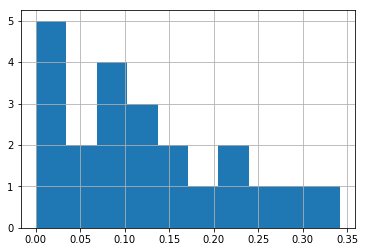

In [26]:
thefts = dist_pred_arrest['Theft Arrest Rate']
thefts.hist()

In [27]:
# want to predict whether an arrest was made from the district. So y is arrests, X is districts
y = dist_pred_arrest['Theft Arrest Rate']
X = districts
model = sm.OLS(y,X)
results = model.fit()

So I have shown that there is not likely a linear relationship between district and theft arrest rate - check on A3

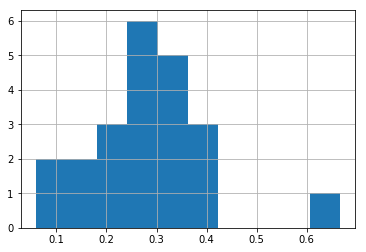

In [28]:
battery = dist_pred_arrest['Battery Arrest Rate']
battery.hist()

In [29]:
def arrest_to_int(string):
    if string == True:
        return 1
    elif string == False:
        return 0
crimes['ArrestInts'] = crimes['Arrest'].apply(arrest_to_int)

# Determine how arrest is predicted by Type of Crime

In [30]:
outcome, predictors = patsy.dmatrices('ArrestInts ~ Type',crimes)
predictors = sm.add_constant(predictors)
model = sm.OLS(outcome,predictors)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             ArrestInts   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     84.89
Date:                Fri, 15 Mar 2019   Prob (F-statistic):          6.44e-266
Time:                        11:18:17   Log-Likelihood:                -613.80
No. Observations:                1999   AIC:                             1274.
Df Residuals:                    1976   BIC:                             1402.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                -4.274e-15      0.165  -2.58e-14      1.000      -0.324       0.324
Type[T.assault]                              0.1613      0.169      0.955      0.340      -0.170       0.493
Type[T.battery]                              0.2560      0.166      1.540      0.124      -0.070       0.582
Type[T.burglary]                             0.0244      0.168      0.145      0.885      -0.305       0.354
Type[T.criminal damage]                      0.0829      0.167      0.497      0.619      -0.244       0.410
Type[T.criminal trespass]                    0.7966      0.171      4.660      0.000       0.461       1.132
Type[T.deceptive practice]                   0.2338      0.170      1.378      0.168      -0.099       0.567
Type[T.gambling]                             1.0000      0.370      2.703      0.007       0.275       1.725
Type[T.interference with public officer]     1.0000      0.253      3.957      0.000       0.504       1.496
Type[T.intimidation]                      3.861e-15      0.370   1.04e-14      1.000      -0.725       0.725
Type[T.kidnapping]                        8.665e-16      0.287   3.02e-15      1.000      -0.562       0.562
Type[T.liquor law violation]                 1.0000      0.253      3.957      0.000       0.504       1.496
Type[T.motor vehicle theft]                  0.0465      0.169      0.275      0.783      -0.285       0.378
Type[T.narcotics]                            1.0000      0.167      6.000      0.000       0.673       1.327
Type[T.offense involving children]           0.2667      0.186      1.432      0.152      -0.098       0.632
Type[T.other]                                0.1571      0.168      0.937      0.349      -0.172       0.486
Type[T.prostitution]                         1.0000      0.214      4.683      0.000       0.581       1.419
Type[T.public peace violation]               0.7368      0.182      4.048      0.000       0.380       1.094
Type[T.robbery]                              0.0175      0.171      0.103      0.918      -0.318       0.353
Type[T.sex offense]                          0.5000      0.234      2.137      0.033       0.041       0.959
Type[T.sexual assault]                       0.1429      0.207      0.689      0.491      -0.264       0.550
Type[T.theft]                                0.1436      0.166      0.864      0.388      -0.183       0.470
Type[T.weapons violation]                    0.8000      0.186      4.297      0.000       0.435       1.165
==============================================================================
Omnibus:                      561.636   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1223.321
Skew:       

# Predict arrest from District

In [31]:
outcome, predictors = patsy.dmatrices('ArrestInts ~ District',crimes)
predictors = sm.add_constant(predictors)
model = sm.OLS(outcome,predictors)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             ArrestInts   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.995
Date:                Fri, 15 Mar 2019   Prob (F-statistic):             0.0458
Time:                        11:18:21   Log-Likelihood:                -1276.8
No. Observations:                1999   AIC:                             2558.
Df Residuals:                    1997   BIC:                             2569.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3345      0.020     17.086      0.000       0.296       0.373
District      -0.0029      0.001     -1.999      0.046      -0.006   -5.51e-05
==============================================================================
Omnibus:                     2639.245   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              377.670
Skew:                           0.864   Prob(JB):                     9.77e-83
Kurtosis:                       1.756   Cond. No.                         25.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Determine whether arrest is predicted by Type of Crime or District

<BarContainer object of 23 artists>

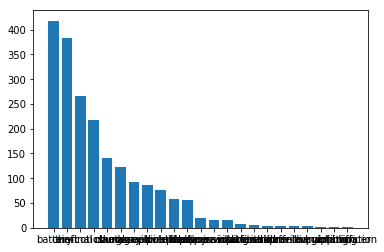

In [45]:

plt.bar(crimes.Type.value_counts().index, crimes.Type.value_counts())
# rotate labels

In [46]:
crimes.Type.value_counts()

battery                             418
theft                               383
narcotics                           266
criminal damage                     217
other                               140
burglary                            123
assault                              93
motor vehicle theft                  86
deceptive practice                   77
criminal trespass                    59
robbery                              57
public peace violation               19
weapons violation                    15
offense involving children           15
sexual assault                        7
prostitution                          6
arson                                 4
sex offense                           4
interference with public officer      3
liquor law violation                  3
kidnapping                            2
gambling                              1
intimidation                          1
Name: Type, dtype: int64

In [59]:
ind = (crimes.Type=='battery').values | (crimes.Type=='theft').values |  (crimes.Type=='narcotics').values |  (crimes.Type=='criminal damage').values 




In [67]:
crimes['District'] = crimes['District'].astype(str)

In [68]:
binomial_model = smf.glm(formula='ArrestInts ~ Type + District', data=crimes.loc[ind,:] , family=sm.families.Binomial())
binomial_results = binomial_model.fit()
binomial_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             ArrestInts   No. Observations:                 1284
Model:                            GLM   Df Residuals:                     1259
Model Family:                Binomial   Df Model:                           24
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -435.77
Date:                Fri, 15 Mar 2019   Deviance:                       871.54
Time:                        11:49:36   Pearson chi2:                 1.01e+03
No. Iterations:                    24   Covariance Type:             nonrobust
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.0368      0.399     -0.092      0.927      -0.819       0.745
Type[T.criminal damage]    -1.3715      0.279     -4.918      0.000      -1.918      -0.825
Type[T.narcotics]          26.8463   1.29e+04      0.002      0.998   -2.53e+04    2.53e+04
Type[T.theft]              -0.9839      0.205     -4.791      0.000      -1.386      -0.581
District[T.10]             -1.6589      0.612     -2.708      0.007      -2.859      -0.458
District[T.11]             -2.2561      0.647     -3.488      0.000      -3.524      -0.988
District[T.12]             -1.1824      0.581     -2.035      0.042      -2.321      -0.043
District[T.14]             -0.9574      0.543     -1.763      0.078      -2.022       0.107
District[T.15]             -0.7664      0.587     -1.306      0.191      -1.916       0.383
District[T.16]             -0.7844      0.581     -1.350      0.177      -1.923       0.354
District[T.17]             -1.0718      0.589     -1.821      0.069      -2.225       0.082
District[T.18]              0.1857      0.461      0.403      0.687      -0.718       1.089
District[T.19]             -1.0291      0.613     -1.679      0.093      -2.230       0.172
District[T.2]              -0.7582      0.527     -1.439      0.150      -1.791       0.274
District[T.20]             -2.0089      1.103     -1.822      0.068      -4.170       0.152
District[T.22]             -1.6201      0.650     -2.493      0.013      -2.894      -0.346
District[T.24]             -1.0305      0.623     -1.654      0.098      -2.252       0.191
District[T.25]             -0.4586      0.474     -0.967      0.334      -1.388       0.471
District[T.3]              -0.6609      0.501     -1.320      0.187      -1.643       0.321
District[T.4]              -1.0879      0.507     -2.146      0.032      -2.082      -0.094
District[T.5]              -1.2347      0.543     -2.273      0.023      -2.300      -0.170
District[T.6]              -0.4847      0.525     -0.923      0.356      -1.514       0.545
District[T.7]              -1.7626      0.576     -3.062      0.002      -2.891      -0.634
District[T.8]              -1.0810      0.511     -2.115      0.034      -2.083      -0.079
District[T.9]              -0.8942      0.573     -1.560      0.119      -2.018       0.229
===========================================================================================
"""

In [ ]:
# want to predict whether an arrest was made from the district. So y is arrest rate, X is districts
outcome, predictors = patsy.dmatrices('ArrestInts ~ Type + District',crimes)
predictors = sm.add_constant(predictors)
model = sm.OLS(outcome,predictors)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             ArrestInts   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                 1.669e+05
Date:                Thu, 14 Mar 2019   Prob (F-statistic):               0.00
Time:                        19:15:08   Log-Likelihood:            -2.1637e+06
No. Observations:             6802128   AIC:                         4.328e+06
Df Residuals:                 6802094   BIC:                         4.328e+06
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                     0.1294      0.003     41.142      0.000       0.123       0.136
Type[T.assault]                               0.1006      0.003     31.633      0.000       0.094       0.107
Type[T.battery]                               0.0976      0.003     30.954      0.000       0.091       0.104
Type[T.burglary]                             -0.0729      0.003    -22.904      0.000      -0.079      -0.067
Type[T.concealed carry license violation]     0.8096      0.019     42.608      0.000       0.772       0.847
Type[T.criminal damage]                      -0.0597      0.003    -18.870      0.000      -0.066      -0.053
Type[T.criminal trespass]                     0.6011      0.003    186.204      0.000       0.595       0.607
Type[T.deceptive practice]                    0.0357      0.003     11.140      0.000       0.029       0.042
Type[T.domestic violence]                     0.8703      0.333      2.617      0.009       0.218       1.522
Type[T.gambling]                              0.8627      0.004    206.108      0.000       0.855       0.871
Type[T.homicide]                              0.3403      0.005     73.451      0.000       0.331       0.349
Type[T.human trafficking]                    -0.0189      0.045     -0.416      0.677      -0.108       0.070
Type[T.interference with public officer]      0.7878      0.004    190.861      0.000       0.780       0.796
Type[T.intimidation]                          0.0453      0.006      7.377      0.000       0.033       0.057
Type[T.kidnapping]                           -0.0192      0.005     -3.735      0.000      -0.029      -0.009
Type[T.liquor law violation]                  0.8609      0.004    204.600      0.000       0.853       0.869
Type[T.motor vehicle theft]                  -0.0392      0.003    -12.264      0.000      -0.045      -0.033
Type[T.narcotics]                             0.8639      0.003    273.071      0.000       0.858       0.870
Type[T.non-criminal]                         -0.0435      0.023     -1.915      0.055      -0.088       0.001
Type[T.obscenity]                             0.6891      0.014     49.131      0.000       0.662       0.717
Type[T.offense involving children]            0.0806      0.004     23.008      0.000       0.074       0.087
Type[T.other]                                 0.0485      0.003     15.235      0.000       0.042       0.055
Type[T.other narcotic violation]              0.5793      0.030     19.291      0.000       0.520       0.638
Type[T.prostitution]                          0.8659      0.003    255.675      0.000       0.859       0.873
Type[T.public indecency]                      0.8637      0.026     33.018      0.000       0.812       0.915
Typ

In [ ]:
low_p = crimes[(crimes['Type'] == 'assault') | (crimes['Type'] == 'battery') | (crimes['Type'] == 'sex offense') | (crimes['Type'] == 'weapons violation') | (crimes['Type'] == 'public peace violation') | (crimes['Type'] == 'prositution') | (crimes['Type'] == 'liquor law violation') | (crimes['Type'] == 'criminal trespass') | (crimes['Type'] == 'interference with public officer') | (crimes['Type'] == 'narcotics') | (crimes['Type'] == 'gambling')]





In [ ]:
low_p['Type'].unique()

array(['battery', 'narcotics', 'weapons violation',
       'public peace violation', 'assault', 'criminal trespass',
       'interference with public officer', 'liquor law violation',
       'sex offense', 'gambling'], dtype=object)

In [ ]:
# want to predict whether an arrest was made from the district. So y is arrest rate, X is districts
outcome, predictors = patsy.dmatrices('ArrestInts ~ Type + District',low_p)
predictors = sm.add_constant(predictors)
model = sm.OLS(outcome,predictors)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             ArrestInts   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                 2.458e+05
Date:                Thu, 14 Mar 2019   Prob (F-statistic):               0.00
Time:                        19:17:33   Log-Likelihood:            -1.1257e+06
No. Observations:             2762180   AIC:                         2.251e+06
Df Residuals:                 2762169   BIC:                         2.251e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    0.2230      0.001    338.359      0.000       0.222       0.224
Type[T.battery]                             -0.0031      0.001     -4.762      0.000      -0.004      -0.002
Type[T.criminal trespass]                    0.5006      0.001    502.556      0.000       0.499       0.503
Type[T.gambling]                             0.7623      0.003    247.589      0.000       0.756       0.768
Type[T.interference with public officer]     0.6869      0.003    230.195      0.000       0.681       0.693
Type[T.liquor law violation]                 0.7584      0.003    243.420      0.000       0.752       0.764
Type[T.narcotics]                            0.7631      0.001   1080.796      0.000       0.762       0.764
Type[T.public peace violation]               0.4111      0.002    234.783      0.000       0.408       0.415
Type[T.sex offense]                          0.0741      0.002     31.479      0.000       0.069       0.079
Type[T.weapons violation]                    0.5634      0.001    383.817      0.000       0.561       0.566
District                                     0.0007   3.27e-05     22.088      0.000       0.001       0.001
==============================================================================
Omnibus:                   329437.921   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           459818.648
Skew:                           0.964   Prob(JB):                         0.00
Kurtosis:                       3.527   Cond. No.                         188.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(results, 0, ax=ax)

In [ ]:
rate_theft = dist_pred_arrest['Theft Arrest Rate'].values
rate_battery = dist_pred_arrest['Battery Arrest Rate'].values
rate_damage = dist_pred_arrest['Criminal Damage Arrest Rate'].values

In [ ]:
st_theft, p_theft = stats.normaltest(rate_theft)
st_battery, p_battery = stats.normaltest(rate_theft)
st_damage, p_damage = stats.normaltest(rate_theft)

In [ ]:
#  This plots a histogram, with the hypothetical normal distribution (with same mean and variance)
xs = np.arange(rate_theft.min(), rate_theft.max(), 0.00001)
fit = stats.norm.pdf(xs, np.mean(rate_theft), np.std(rate_theft))
plt.plot(xs, fit, label='Normal Dist.', lw=4)
plt.hist(rate_theft, normed=True, label='Actual Data');
plt.title('Theft Arrest Rate Data')
plt.legend();

In [ ]:
#  This plots a histogram, with the hypothetical normal distribution (with same mean and variance)
xs = np.arange(rate_battery.min(), rate_battery.max(), 0.00001)
fit = stats.norm.pdf(xs, np.mean(rate_battery), np.std(rate_battery))
plt.plot(xs, fit, label='Normal Dist.', lw=4)
plt.hist(rate_battery, normed=True, label='Actual Data');
plt.title('Battery Arrest Rate Data')
plt.legend();

In [ ]:
#  This plots a histogram, with the hypothetical normal distribution (with same mean and variance)
xs = np.arange(rate_damage.min(), rate_damage.max(), 0.00001)
fit = stats.norm.pdf(xs, np.mean(rate_damage), np.std(rate_damage))
plt.plot(xs, fit, label='Normal Dist.', lw=4)
plt.hist(rate_damage, normed=True, label='Actual Data');
plt.title('Criminal Damage Arrest Rate Data')
plt.legend();

In [ ]:
theft_arrest_average = rate_theft.mean()
battery_arrest_average = rate_battery.mean()
damage_arrest_average = rate_damage.mean()

In [ ]:
print('Theft Arrest Rate Average\tBattery Arrest Average\tCriminal Damage Arrest Average\n{0}\t\t{1}\t{2}'.format(theft_arrest_average,battery_arrest_average,damage_arrest_average))

Battery is more likely to result in an arrest, on average, doesn't matter where you are. Criminal damage is the least likely to result in an arrest.

Now, I should move onto the actual analysis of the question: what I want to do is show that there is a significant difference between districts in terms of these averages. Lets try to start with just comparing districts 1 and 2

So my initial findings have indicated that there is in fact a very significant difference between the districts when it comes to the proportion of crimes that result in arrests.

I will now turn the above code into a function to apply the two sample t test to all pairs of districts, which is n^2 time.

In [ ]:
def get_stats(dist_1,dist_2):
    dist_1_battery = dist_1[dist_1['Primary Type'] == 'battery']
    dist_2_battery = dist_2[dist_2['Primary Type'] == 'battery']
    
    dist_1_theft = dist_1[dist_1['Primary Type'] == 'theft']
    dist_2_theft = dist_2[dist_2['Primary Type'] == 'theft']
    
    dist_1_damage = dist_1[dist_1['Primary Type'] == 'criminal damage']
    dist_2_damage = dist_2[dist_2['Primary Type'] == 'criminal damage']

    print('--------Theft Statistics---------\n')
    print('*******First District********')
    print('Theft Arrest Mean:\t{0}'.format(dist_1_theft['Arrest'].mean()))
    print('Number of Thefts:\t{0}'.format(len(dist_1_theft['Arrest'])))
    
    print('*******Second District********')
    print('Theft Arrest Mean:\t{0}'.format(dist_2_theft['Arrest'].mean()))
    print('Number of Thefts:\t{0}'.format(len(dist_2_theft['Arrest'])))

    t_val, p_val = stats.ttest_ind(dist_1_theft['Arrest'], dist_2_theft['Arrest'])
    print('Test Statistic:\t{0}\nP Value:\t{1}'.format(t_val,p_val))

    print('\n--------Battery Statistics---------\n')
    print('*******First District********')
    print('Battery Arrest Mean:\t{0}'.format(dist_1_battery['Arrest'].mean()))
    print('Number of Batteries:\t{0}'.format(len(dist_1_battery['Arrest'])))
    
    print('*******Second District********')
    print('Battery Arrest Mean:\t{0}'.format(dist_2_battery['Arrest'].mean()))
    print('Number of Batteries:\t{0}'.format(len(dist_2_battery['Arrest'])))

    t_val, p_val = stats.ttest_ind(dist_1_battery['Arrest'], dist_2_battery['Arrest'])
    print('Test Statistic:\t{0}\nP Value:\t{1}'.format(t_val,p_val))

    print('\n--------Criminal Damage Statistics---------\n')
    print('*******First District********')
    print('Damage Arrest Mean:\t{0}'.format(dist_1_damage['Arrest'].mean()))
    print('Number of Damages:\t{0}'.format(len(dist_1_damage['Arrest'])))
    
    print('*******Second District********')
    print('Damage Arrest Mean:\t{0}'.format(dist_2_damage['Arrest'].mean()))
    print('Number of Damages:\t{0}'.format(len(dist_2_damage['Arrest'])))

    t_val, p_val = stats.ttest_ind(dist_1_damage['Arrest'], dist_2_damage['Arrest'])
    print('Test Statistic:\t{0}\nP Value:\t{1}'.format(t_val,p_val))


In [ ]:
get_stats(district_cache[2.0],district_cache[4.0])